In [1]:
#imports
import os
import glob
import random
from scipy.io import loadmat
import numpy as np
import cv2

import keras
from tensorflow.keras.layers import (Input,Activation, Conv2D, Dropout, Convolution2D,UpSampling2D)
from tensorflow.keras.layers import (Activation, Conv3D, Dense, Dropout, Flatten,Conv2DTranspose,
                  Add,MaxPooling2D,MaxPooling3D, Input, Concatenate,BatchNormalization)
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.losses import mean_absolute_error
from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.optimizers import Adam
import os, math
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf


Using TensorFlow backend.


In [11]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [9]:
driveroot=os.getcwd()

rgbdir=driveroot+"/NTIRE2020_Train_Clean"
hsdir=driveroot+"/NTIRE2020_Train_Spectral"

hpath=hsdir+'/ARAD_HS_*.mat'
rpath_clean=rgbdir+'/ARAD_HS_*_clean.png'
# print(rgbdir,hsdir,hpath,rpath_clean)

num_samples=450#number of files to load
image_size=128

hlist=glob.glob(hpath)[0:num_samples]
rgblist=glob.glob(rpath_clean)[0:num_samples]
print("number of hyperspectral imgs:",len(hlist))
print("number of rgb images:",len(rgblist))

number of hyperspectral imgs: 450
number of rgb images: 450


In [3]:
#validation sets
x_valdir=driveroot+"/NTIRE2020_Validation_Clean"
y_valdir=driveroot+"/NTIRE2020_Validation_Spectral"

In [4]:
Y_val=np.load(y_valdir+"/ntire2020_hs_validationset_10.npy")
X_val=np.load(x_valdir+"/ntire2020_rgbclean_validationset_10.npy")

In [10]:
# from skimage import img_as_ubyte
def normalize_data(data):
	# print("Normalizing Data ...........................")
	# print(data.shape, data.dtype, "min:",data.min(), "max:",data.max())
	temp = data
	# print(temp.shape, temp.dtype, "min:",temp.min(), "max:",temp.max())
	data = temp/temp.max()
	# print(data.shape, data.dtype, "min:",data.min(), "max:",data.max())
	return data	

def resize_npFile(data, image_size, file_save_path=None, save=False):	
#   print("Resizing the input data .................",data.shape)
  resize_np = np.zeros((data.shape[0],image_size, image_size, data.shape[3]))

  for j in range(data.shape[0]):
    for i in range(data.shape[3]):			
      # cv2.imwrite('org.png',img_as_ubyte(data[j][:,:,i]))
      temp = cv2.resize(data[j][:,:,i],(image_size, image_size), interpolation=cv2.INTER_AREA)	
      resize_np[j][:,:,i] = temp
      # print(data[j].shape, data[j][:,:,i].shape, temp.shape, resize_np[j].shape)			
  if save == True:
    np.save(file_save_path, resize_np)
    print('Successfully Saved .....', file_save_path, resize_np.shape)	
  return resize_np

In [11]:
#normalize
X_val=normalize_data(X_val)
Y_val=normalize_data(Y_val)

#resize
X_val=resize_npFile(X_val, image_size)
Y_val=resize_npFile(Y_val, image_size)

In [12]:
print("Validation set:",Y_val.shape, X_val.shape)

Validation set: (10, 128, 128, 31) (10, 128, 128, 3)


In [13]:
def load_batch_hyper(filelist):
    final_numpyData=np.array(0)
    for i in range(len(filelist)):
        x=loadmat(filelist[i])
        matimg=x['cube']
        final_numpyData=matimg if i==0 else np.stack([final_numpyData,matimg]) if i==1 else np.concatenate([final_numpyData,np.expand_dims(matimg, axis=0)])
    return final_numpyData

y=load_batch_hyper(hlist[5:10])
y.shape

(5, 482, 512, 31)

In [14]:
def load_batch_rgb(filelist):
    final_numpyData=np.array(0)
    for i in range(len(filelist)):
        matimg = cv2.imread(filelist[i])
        final_numpyData=matimg if i==0 else np.stack([final_numpyData,matimg]) if i==1 else np.concatenate([final_numpyData,np.expand_dims(matimg, axis=0)])
    return final_numpyData
x=load_batch_rgb(rgblist[5:10])
x.shape

(5, 482, 512, 3)

In [15]:
def imageLoader(files_x,files_y, batch_size):
    L = len(files_x)
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X = load_batch_rgb(files_x[batch_start:limit])
            Y = load_batch_hyper(files_y[batch_start:limit])

            #normalize
            X=normalize_data(X)
            Y=normalize_data(Y)

            #resize
            X=resize_npFile(X, image_size)
            Y=resize_npFile(Y, image_size)

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [16]:
def rgb2hs_cnn(image_size):
		model = Sequential()
		model.add(Convolution2D(32, kernel_size=(3, 3), padding='same',
	                            input_shape=(image_size,image_size,3)))
		model.add(Activation('relu'))
		model.add(Convolution2D(32, kernel_size=(3, 3),padding='same'))
		model.add(Activation('relu'))
		# model.add(Dropout(0.25))
		model.add(Convolution2D(64, kernel_size=(3, 3), padding='same'))
		model.add(Activation('relu'))
		model.add(Convolution2D(64, kernel_size=(3, 3), padding='same'))
		model.add(Activation('relu'))
		# model.add(Dropout(0.25))

		model.add(Convolution2D(31, kernel_size=(3, 3), padding='same'))
		model.add(Activation('relu'))

		return model

In [17]:
#model params
epochs=5
batch_size=8
lr=0.0001

initial_epoch=0

image_size=128

model_save_dir=driveroot+"/models"
model_name="cnn_normalised_5_loc"
version=3

In [19]:
model=rgb2hs_cnn(image_size)    
model.compile(loss='mean_absolute_error', optimizer=Adam(lr=lr), metrics=['mae','mse'])
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_save_dir+'/model_'+str(model_name)+'_'+str(version)+'_'+str(epochs)+'.h5',
                                             monitor='loss',verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=50)
csv_logger = tf.keras.callbacks.CSVLogger(model_save_dir + "/tr_-v"+str(version)+".csv", separator=',', append=True)
history=model.fit(imageLoader(rgblist,hlist,batch_size), validation_data=(X_val, Y_val), steps_per_epoch=math.ceil(num_samples/batch_size), epochs=epochs,verbose=1,callbacks=[checkpoint, csv_logger], shuffle=True)

# history = model.fit(x=X_data, y=Y_data, batch_size=batch_size, epochs=epochs, verbose=1, initial_epoch=initial_epoch,
 					# validation_split=0.2,callbacks=[checkpoint, csv_logger], shuffle=False)
# history = model.fit(x=X_data, y=Y_data, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2, 
                            # validation_data=(X_val, Y_val), shuffle=True)

Epoch 1/5
57/57 [==============================] - 489s 9s/step - mse: 0.0302 - loss: 0.1059 - mae: 0.1059 - val_mse: 0.0129 - val_mae: 0.0727 - val_loss: 0.0727
Epoch 2/5
57/57 [==============================] - 521s 9s/step - mse: 0.0071 - loss: 0.0484 - mae: 0.0484 - val_mse: 0.0064 - val_mae: 0.0489 - val_loss: 0.0489
Epoch 3/5
57/57 [==============================] - 443s 8s/step - mse: 0.0032 - loss: 0.0319 - mae: 0.0319 - val_mse: 0.0035 - val_mae: 0.0347 - val_loss: 0.0347
Epoch 4/5
57/57 [==============================] - 413s 7s/step - mse: 0.0025 - loss: 0.0272 - mae: 0.0272 - val_mse: 0.0032 - val_mae: 0.0331 - val_loss: 0.0331
Epoch 5/5
57/57 [==============================] - 420s 7s/step - mse: 0.0022 - loss: 0.0256 - mae: 0.0256 - val_mse: 0.0030 - val_mae: 0.0318 - val_loss: 0.0318


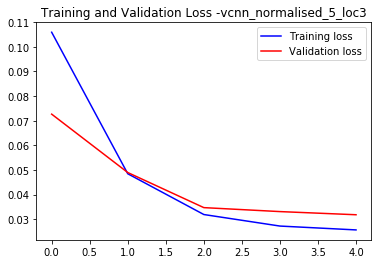

In [20]:
import matplotlib
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], 'b', label='Training loss')
plt.plot(history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and Validation Loss -v'+str(model_name)+str(version))
plt.legend()
plt.savefig(os.path.join(model_save_dir, str(model_name)+'_train_loss_'+str(version)+'_'+str(epochs)+'.png')) 
# plt.show()

In [22]:
history.history

{'loss': [0.10593744367361069,
  0.048447560518980026,
  0.031880736351013184,
  0.027198592200875282,
  0.025631360709667206],
 'mae': [0.10593744367361069,
  0.048447560518980026,
  0.031880736351013184,
  0.027198592200875282,
  0.025631360709667206],
 'mse': [0.030187590047717094,
  0.007059797644615173,
  0.0032308490481227636,
  0.0025025117211043835,
  0.0022477973252534866],
 'val_loss': [0.07266277074813843,
  0.0489458329975605,
  0.03468646854162216,
  0.033077072352170944,
  0.03179377317428589],
 'val_mae': [0.07266277074813843,
  0.0489458329975605,
  0.03468646854162216,
  0.033077072352170944,
  0.03179377317428589],
 'val_mse': [0.012876343913376331,
  0.006382218096405268,
  0.0035026241093873978,
  0.0031830724328756332,
  0.0029762531630694866]}

In [21]:
model_json = model.to_json()
with open(model_save_dir+'/model_'+str(model_name)+'_'+str(version)+'_'+str(epochs)+'.json', "w+") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(model_save_dir+'/model_'+str(model_name)+'_'+str(version)+'_'+str(epochs)+'.h5')
print("Saved model to disk")

Saved model to disk


In [23]:
sample_x,sample_y=X_val[0],Y_val[0]
y_pred=model.predict(np.expand_dims(sample_x,axis=0))
y_pred.shape

(1, 128, 128, 31)

In [24]:
rmaee=abs(sample_y-y_pred[0])/sample_y
rmaee.shape

(128, 128, 31)

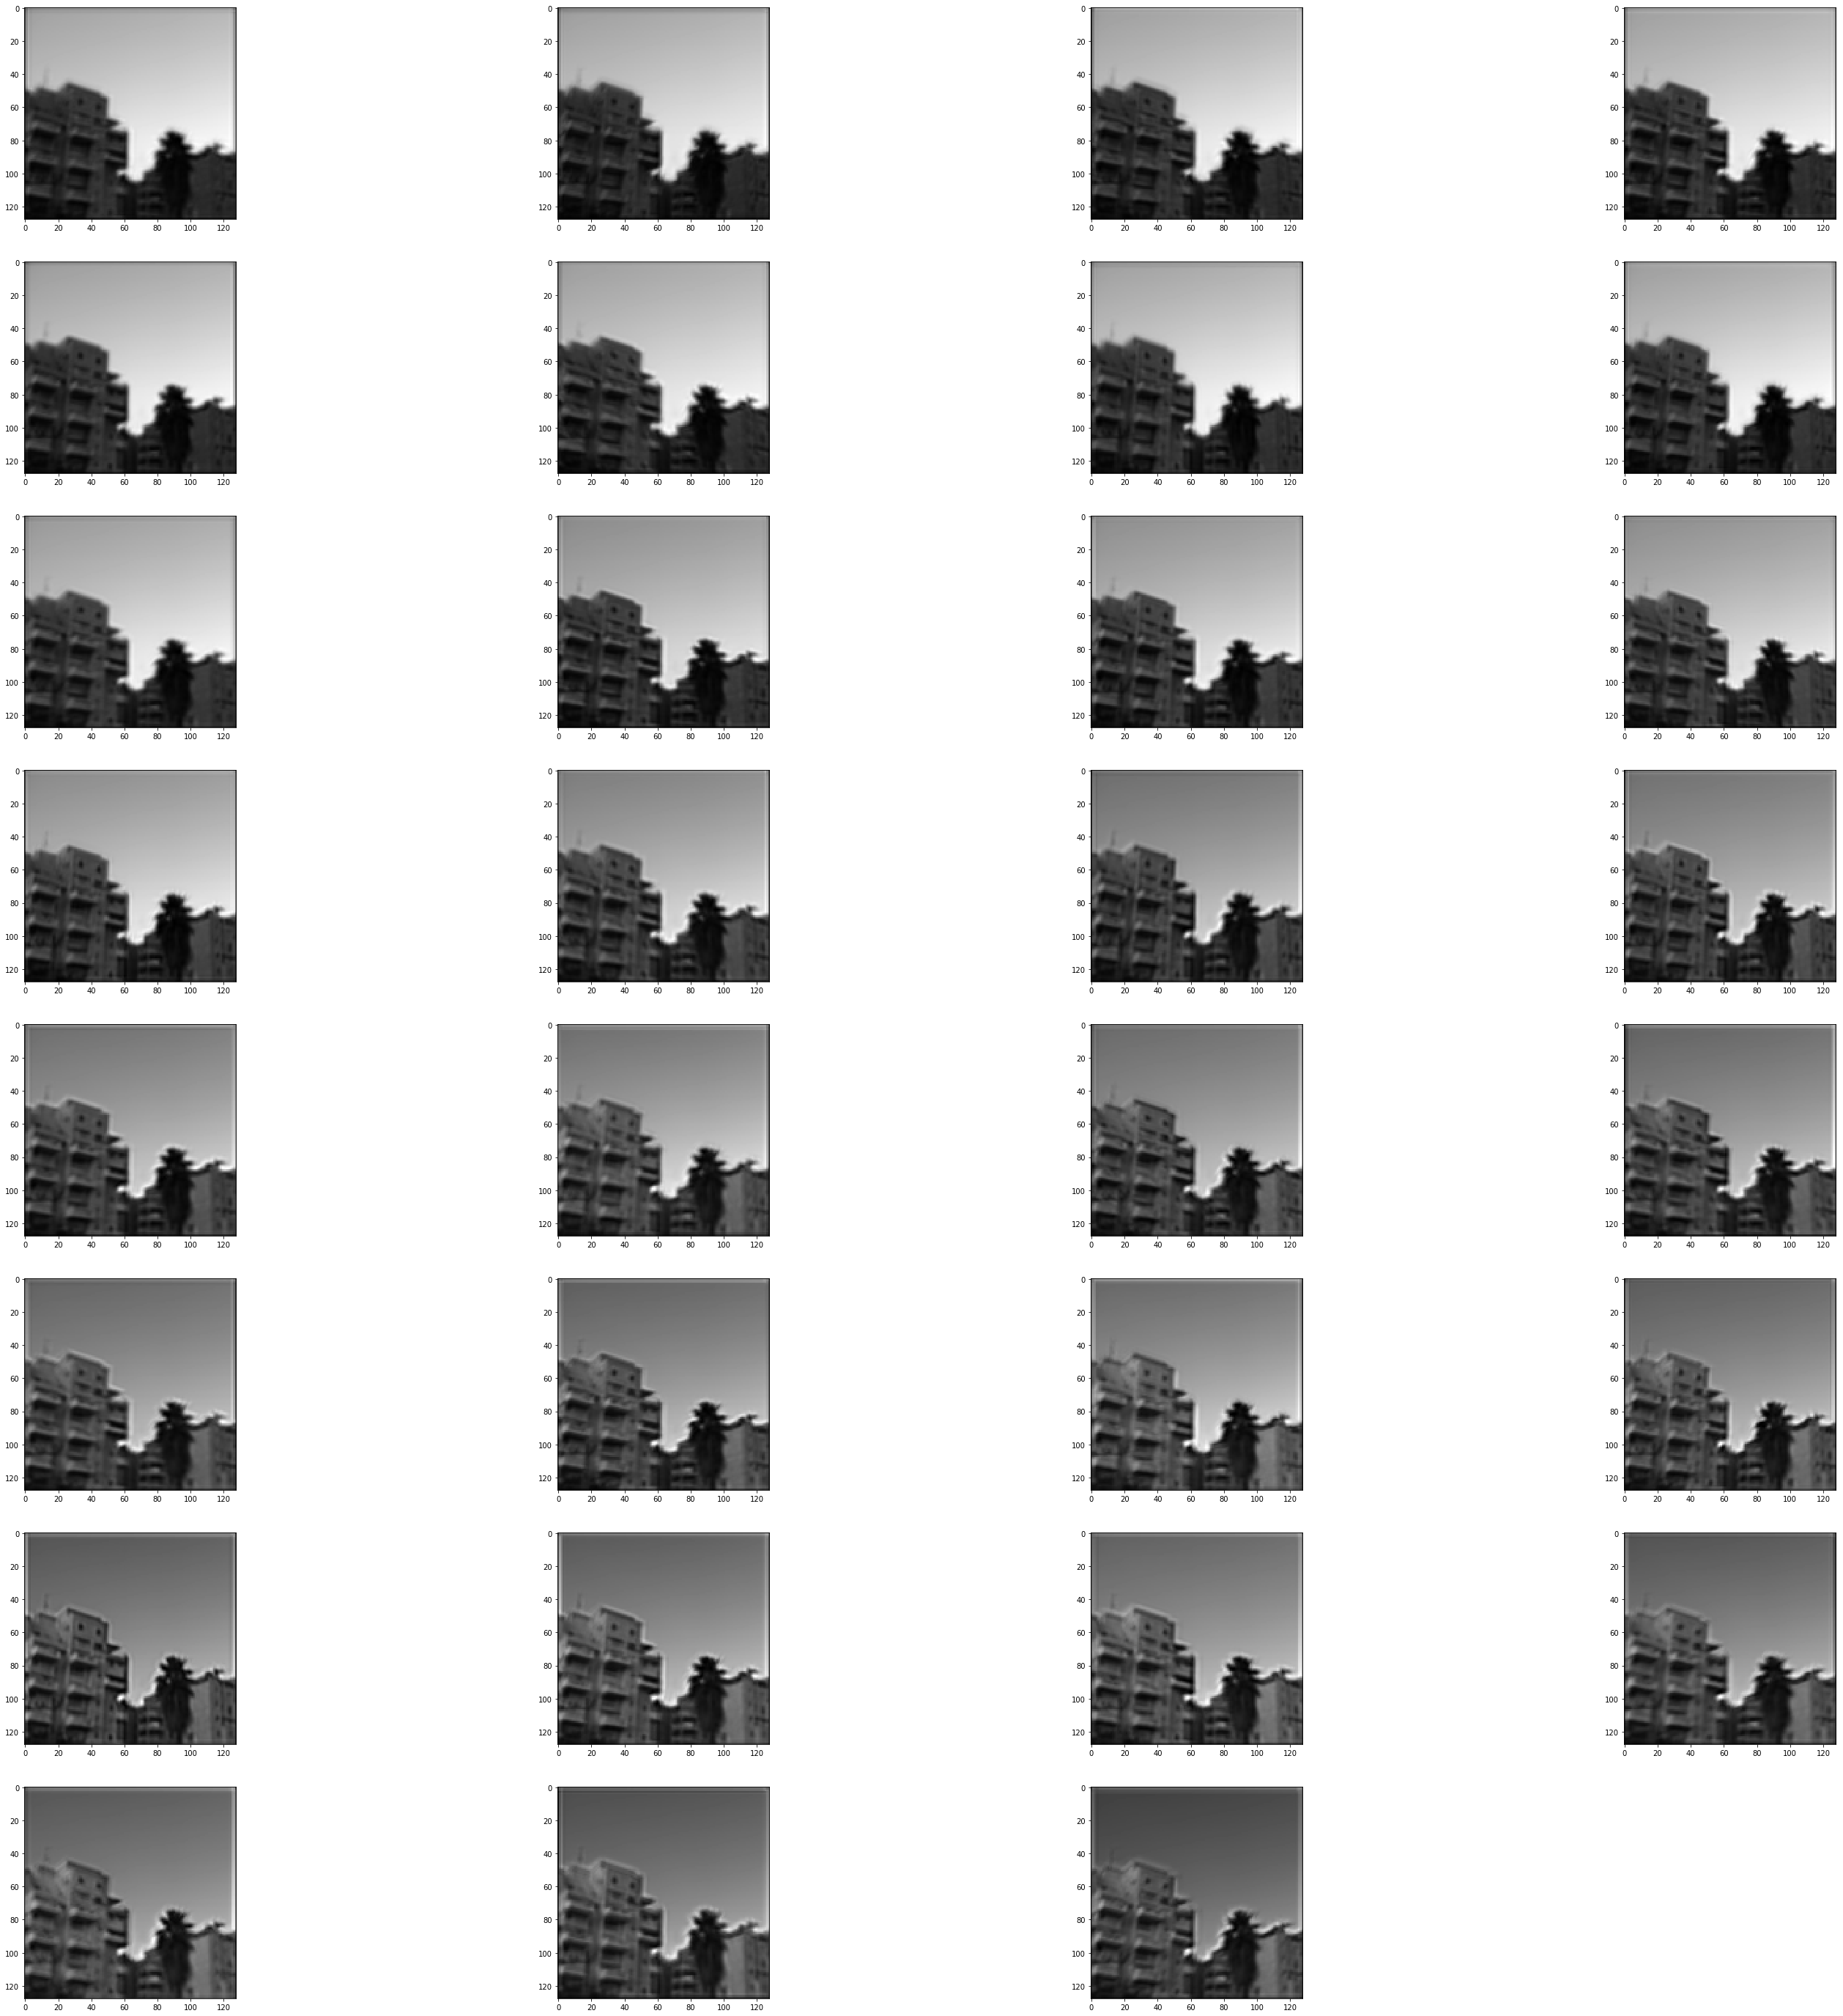

In [26]:
#plotting model output
g=plt.figure(figsize=(50, 50))
for i in range(31):
    plt.subplot(8,4,i+1)
    plt.imshow(y_pred[0,:,:,i],cmap='gray')

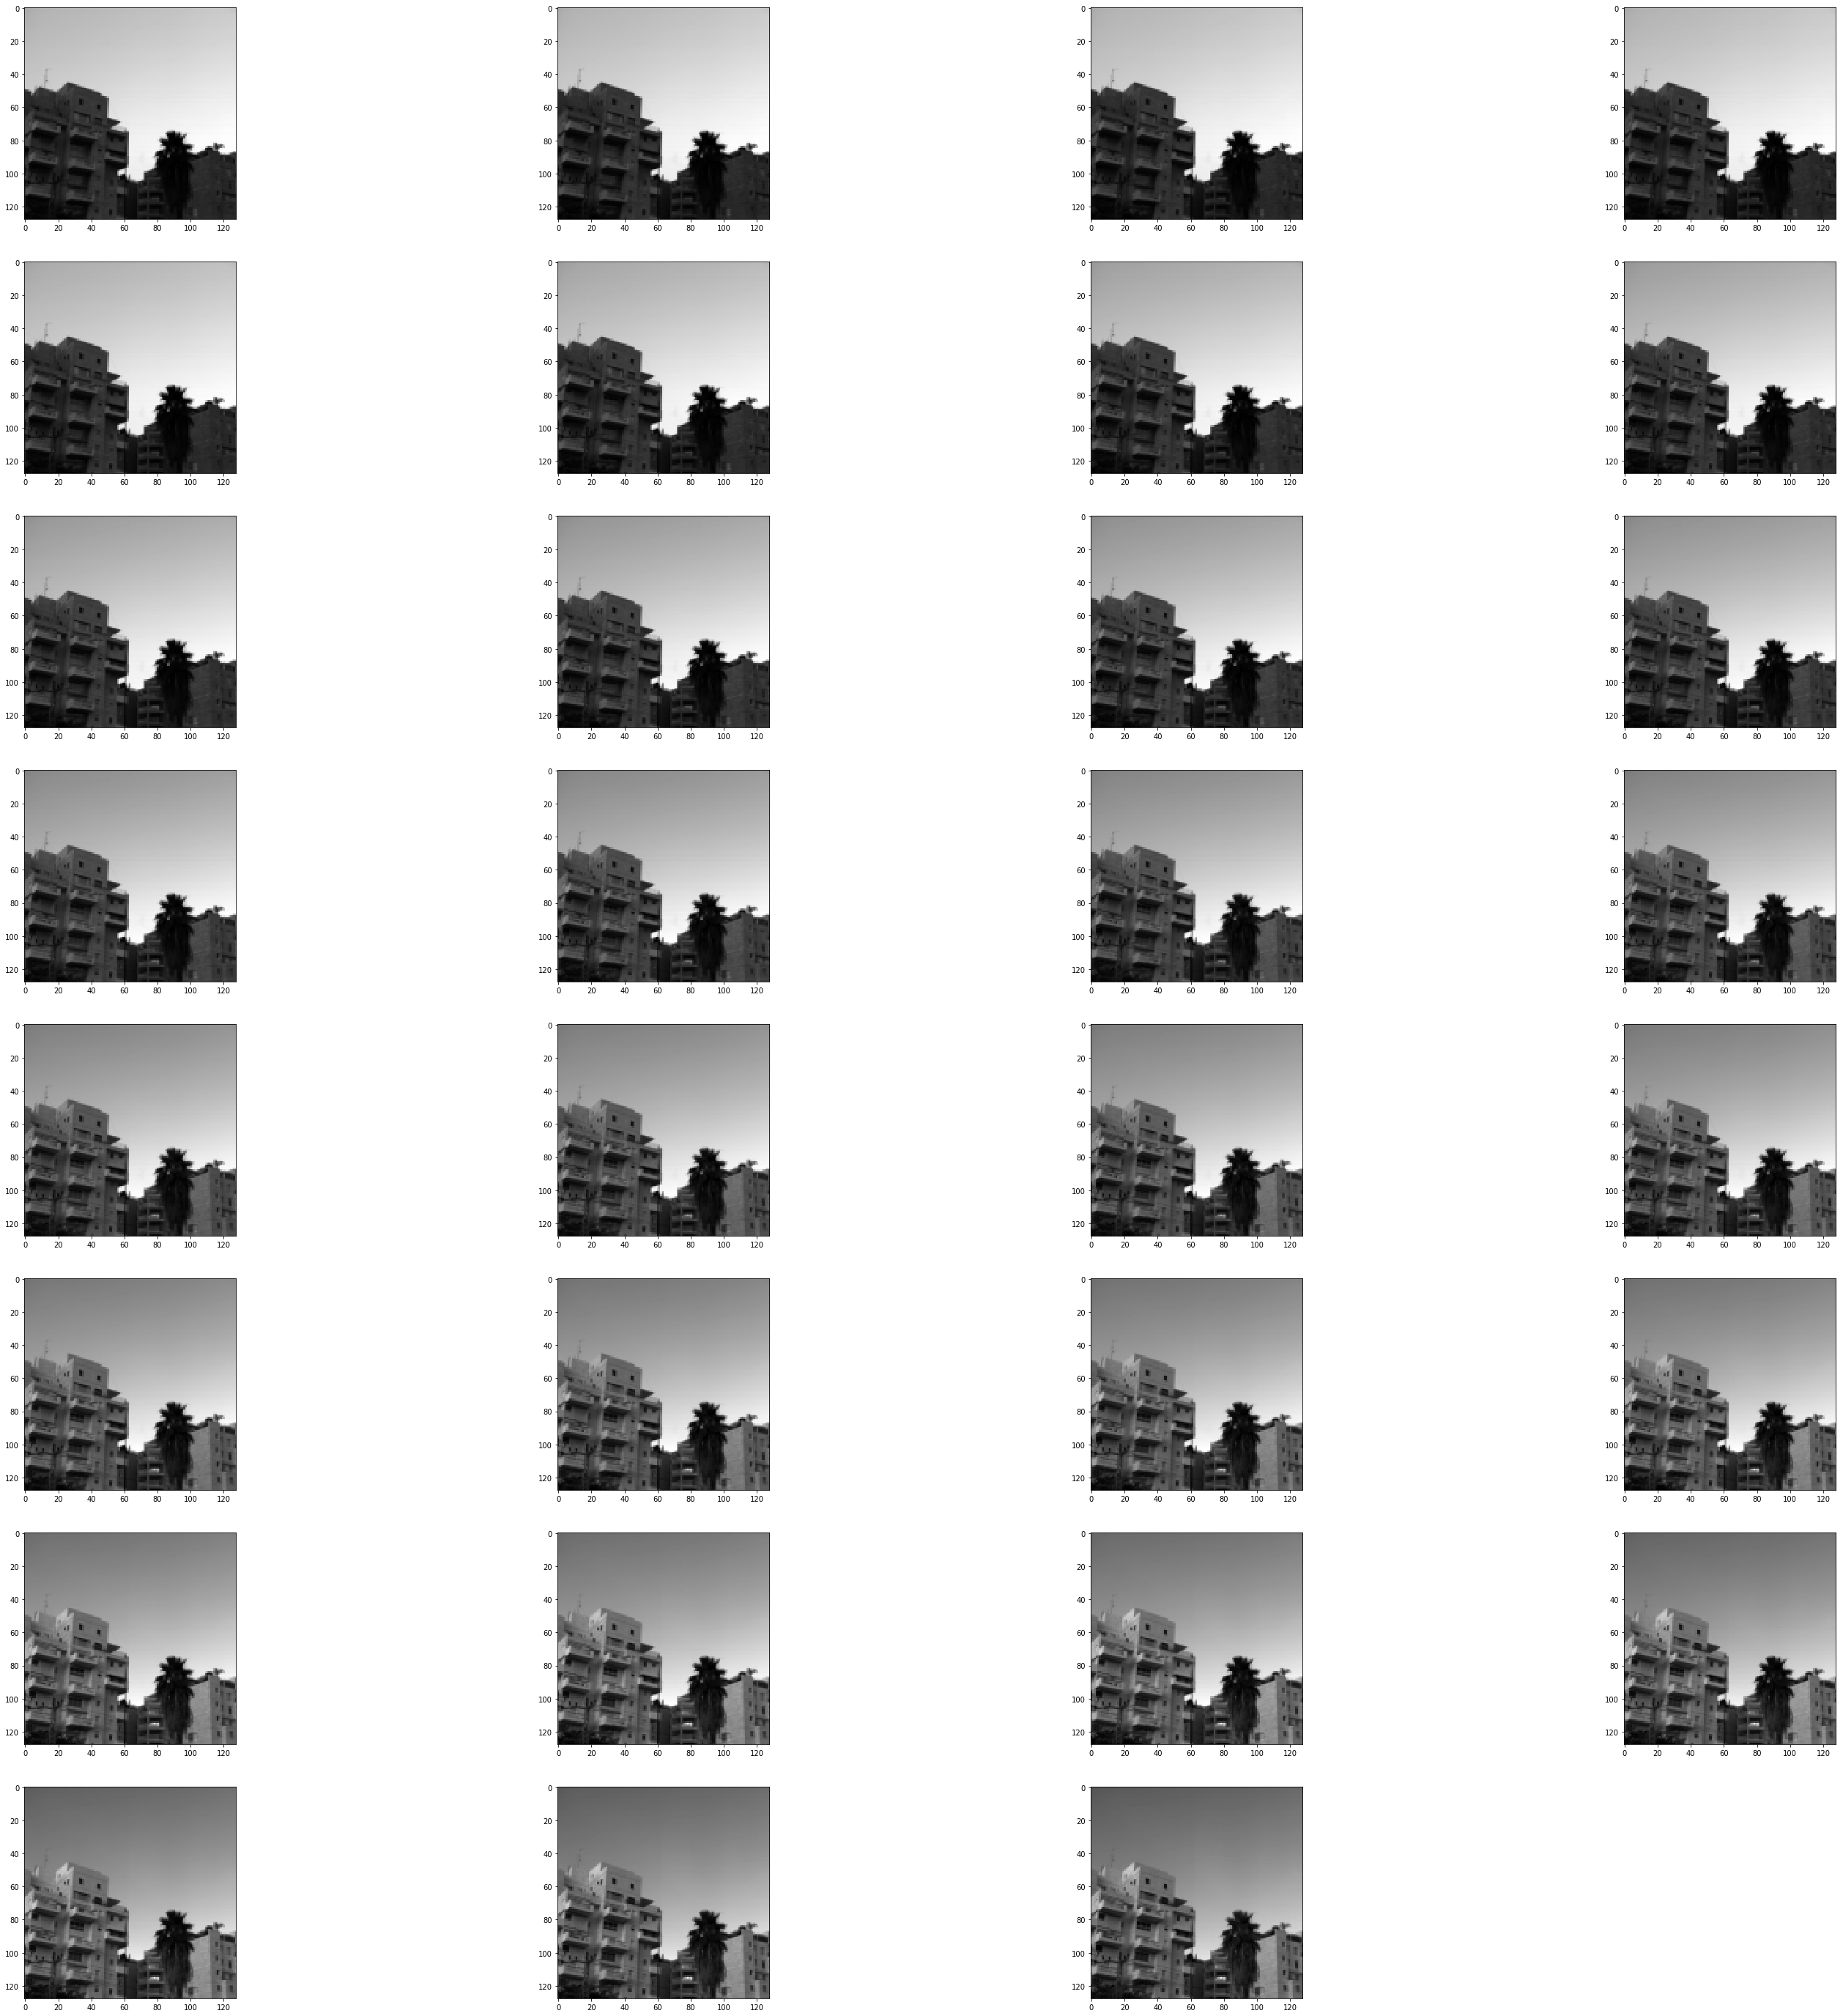

In [27]:
#plotting ground truth

g=plt.figure(figsize=(50, 50))
for i in range(31):
    plt.subplot(8,4,i+1)
    plt.imshow(sample_y[:,:,i],cmap='gray')

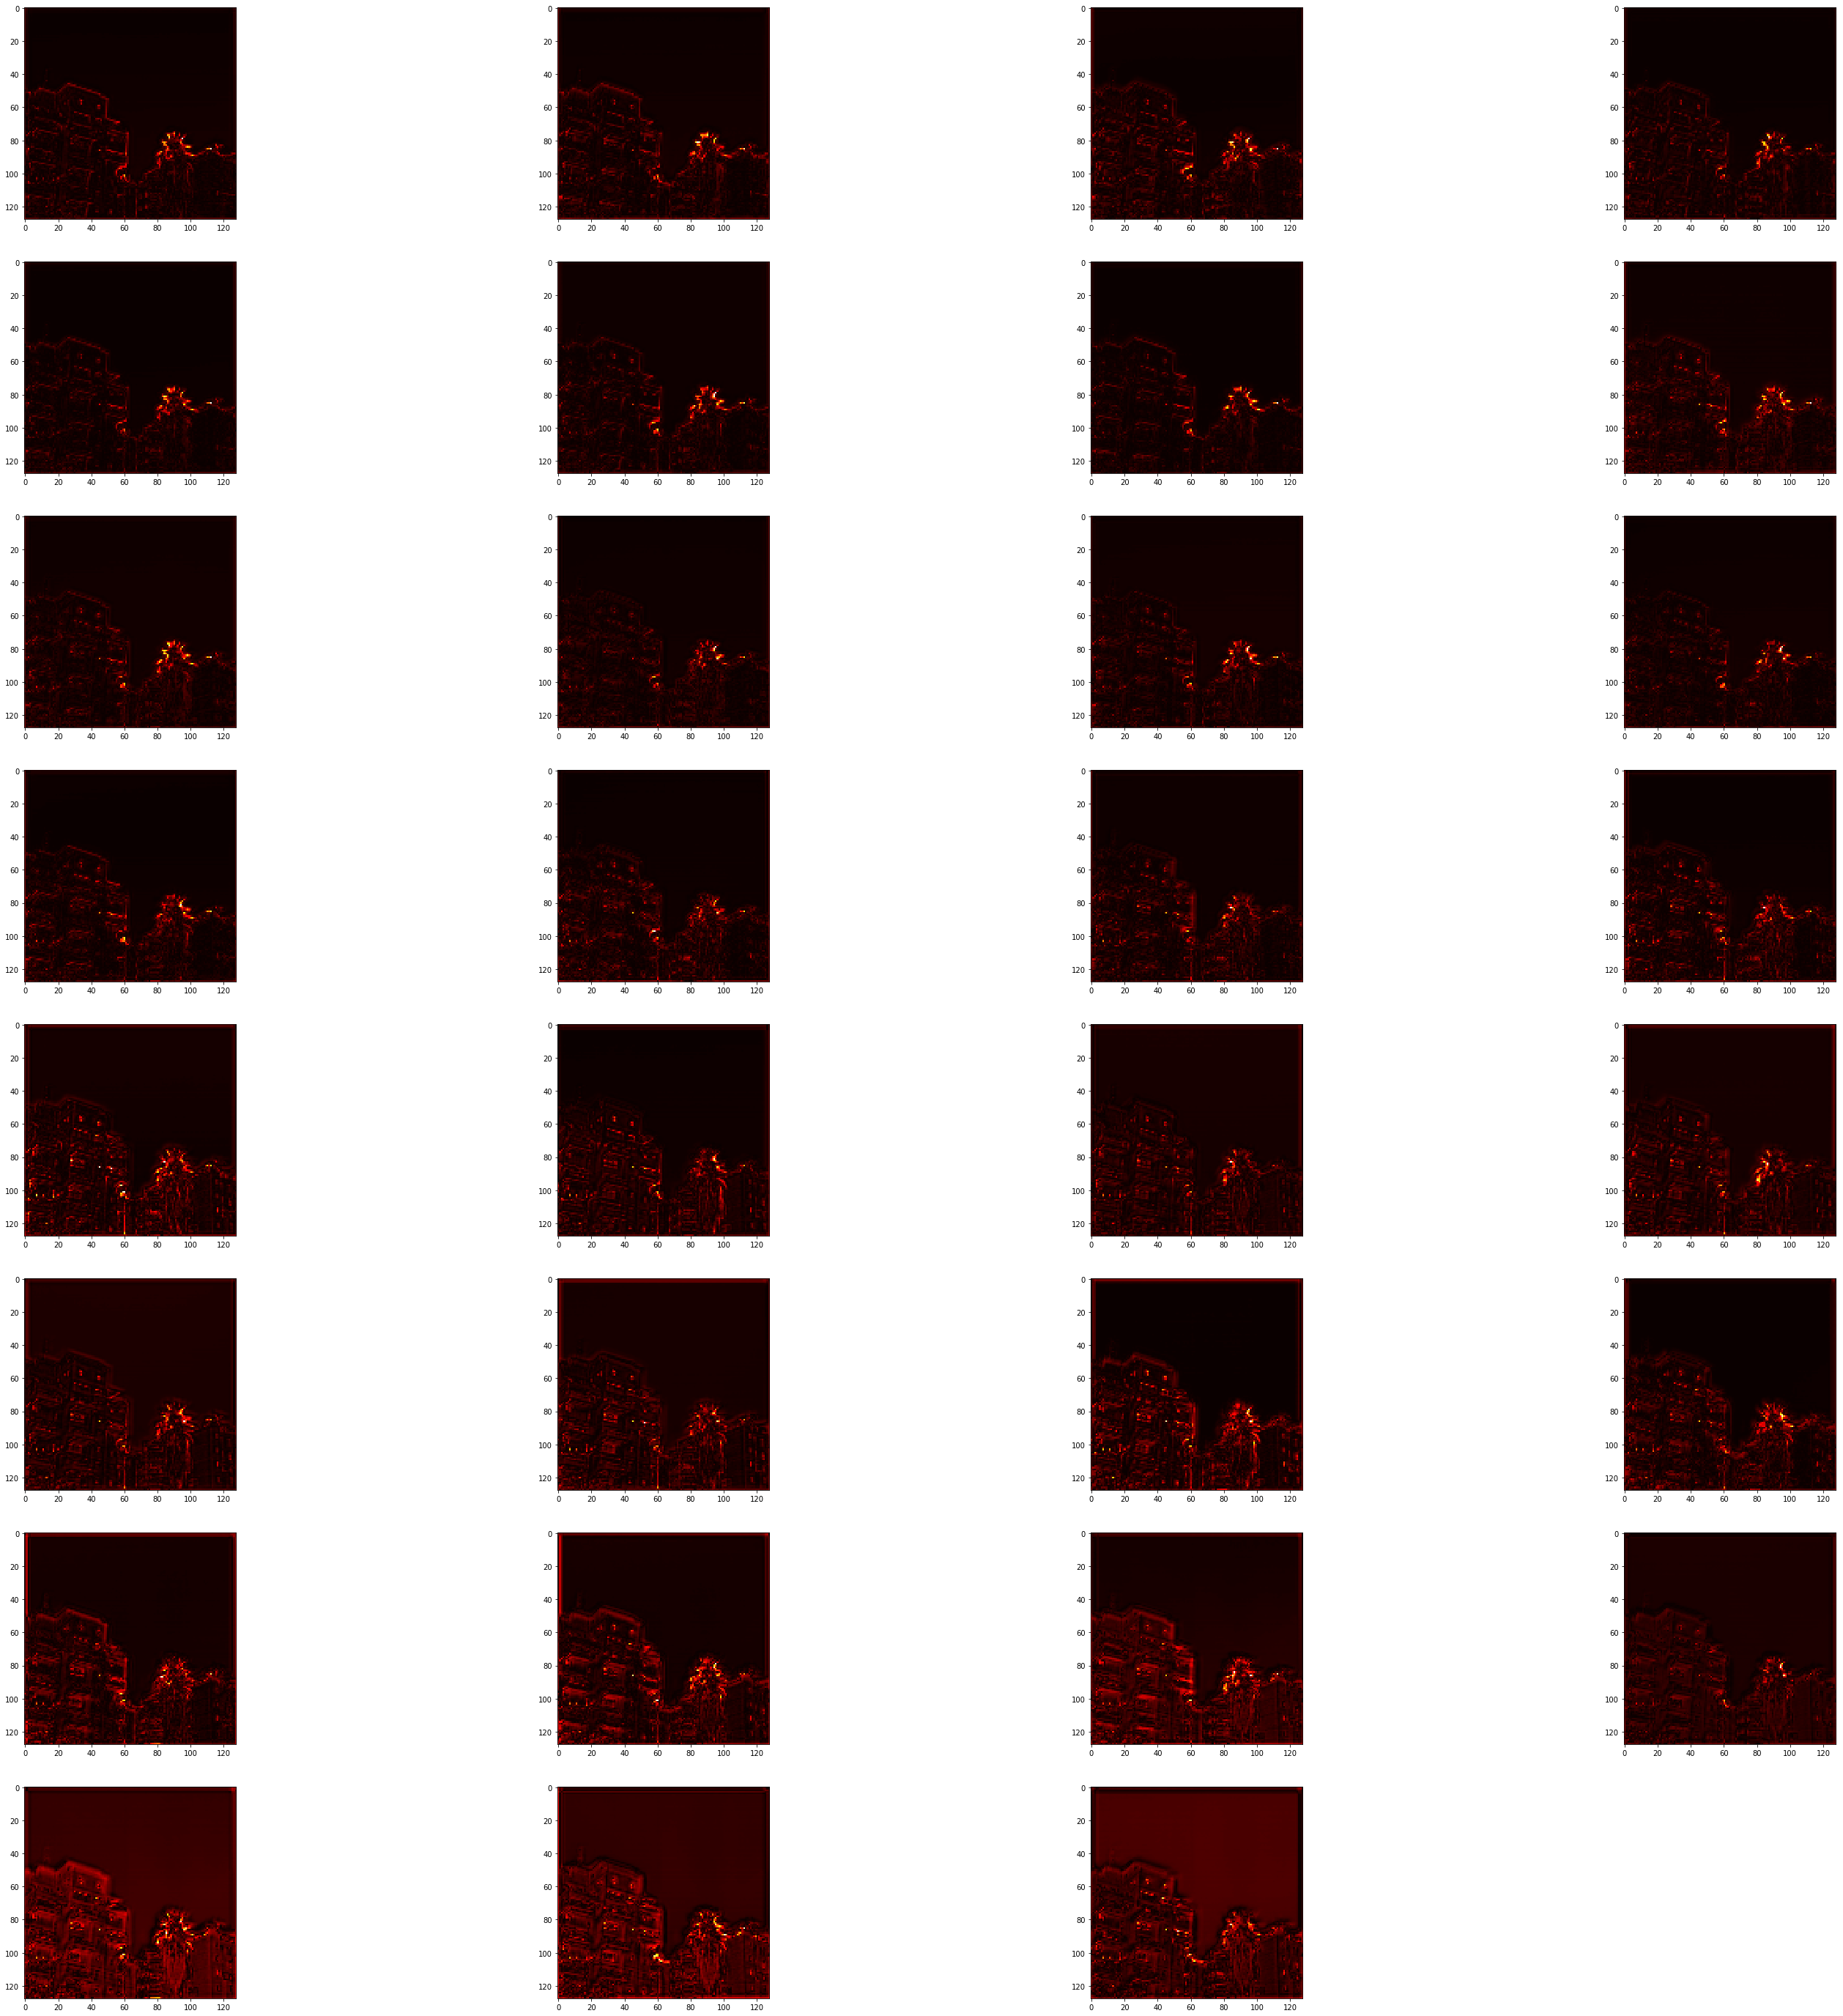

In [25]:
f=plt.figure(figsize=(50, 50))
for i in range(31):
    plt.subplot(8,4,i+1)
    plt.imshow(rmaee[:,:,i],cmap=plt.get_cmap('hot'), interpolation='nearest')
# plt.show()

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17342713936730181118
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2589794805891919352
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11542815054677857941
physical_device_desc: "device: XLA_GPU device"
]
